# Imports

In [1]:
import pandas as pd
import psycopg2

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
from sklearn import metrics
from plot_classification_report import plot_classification_report

# Read Data Set

In [2]:
df = pd.read_csv("mergeData_fixed_time.csv")
df = df.drop('total_time', axis=1) 
df.head()

,pedId,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,...,gender,age,job,LatestDegree,oftenDrive,accidents,yearsDriving,lastDrive(years),speedingTickets,hadCollision
0,1.0,6.978462,0.493644,0.947244,0.813465,-0.000623,13.607109,0.000420,0.021339,0.032907,...,0,32,0,0,2,0,10,1.0,0,0
1,3.0,7.045599,0.504890,0.875541,0.911211,-0.045255,33.663919,0.000176,0.065360,0.002429,...,0,32,0,0,2,0,10,1.0,0,0
2,15.0,10.263041,0.478319,0.817679,0.595013,-0.017068,76.873997,0.001610,0.105119,0.076302,...,0,32,0,0,2,0,10,1.0,0,1
3,2.0,11.669419,0.500661,0.891913,0.522365,0.008028,47.209285,0.000396,0.055982,0.112551,...,0,32,0,0,2,0,10,1.0,0,0
4,4.0,12.187044,0.499769,0.861132,0.558120,0.001881,42.031423,0.000430,0.102442,0.079023,...,0,32,0,0,2,0,10,1.0,0,0


### Context

The data source is created from "thesis_molding_fixed_time.ipynb" from the initial data set of GTA, Driving simulator and demographic data.

&nbsp; Each row cames from every pedestrian that driver cross. So we have many rows for every scenario (depending on how many pedestrians where in that scenario) and many scenarios from every driver (there are 5 scenarios). 
    
&nbsp; We took a previous fixed period of time of every pedestrian (taking a tail of rows from the initial data set of every pedestrian identified) and having as the target feature the result of the collision between the car and the pedestrian.

The columns in this merged data are:
- **index**
- **pedId**: id from the pedestrian crossed
- **speed_total_mean**: mean from speed collected from GTA game in that period of time
- **steering_total_mean**: mean from steering wheel from Driving simulator in that period of time
- **brake_total_mean**: mean from brake pedal from Driving simulator in that period of time
- **throttle_total_mean**: mean from throttle pedal from Driving simulator in that period of time
- **acceleration_total_mean**: mean from acceleration collected from GTA game
- **speed_total_var**: variance from speed collected from GTA game
- **steering_total_var**: variance from steering wheel from Driving simulator
- **brake_total_var**: variance from brake pedal from Driving simulator
- **throttle_total_var**: variance from throttle pedal from Driving simulator
- **acceleration_total_var**: variance from acceleration collected from GTA game
- ~~**total_time**: time in seconds of that period of time (can be different because some pedestrians appear quickly or some drivers where stopped on a traffic light).~~
- **distancePed**: initial distance between the driver and the pedestrian
- **max_speed**: max speed in that period of time
- **PKE**: Agressive driving measure considering drastic movements of speed 
- **PKE_steering**: Agressive driving measure considering drastic movements of steering
- **speed_react**: Actual speed when pedestrian start crossing
- **reaction_time**: time in seconds from when the pedestrian started running until there was a reaction in the driver's brake pedal
- **pedestrianLevel**: Level of pedestrians in that scenario as integer ( {0: Low, 1: Normal, 2: High} )
- **visibilityLevel**: Level of visibility in that scenario as integer ( {0: Low, 1: High})
- **trafficLevel**: Level of traffic in that scenario as integer ( {0: Low, 1: High})
- **gender**: gender of the driver {'Male': 0, 'Female': 1}
- **age**: Age of driver
- **job**: job of the driver {'Student': 0, 'PhD Student': 1, 'Researcher': 2, 'Project Coordinator': 3, 'Research Associate': 4, 'PA': 5, 'Events': 6}
- **LatestDegree**: Last degree of the driver {'Bachelor': 0, 'Master': 1, 'PhD': 2, 'High School': 3, 'Uni Diploma': 4, 'University': 5}
- **OftenDrive**: level from 1 to 5.
- **accidents**: number of accidents in the past
- **yearsDriving**: years driving
- **lastDrive**: last drive (in years)
- **speedingTickets**: speeding tickets receive in the past
- **hadCollision**: False: 0, True: 1
    
The differents scenario were:
- Scenario 1 : Low pedestrian    | High Visibility | Low Traffic
- Scenario 2 : High pedestrian   | High Visibility | Low Traffic
- Scenario 3 : Normal pedestrian | Low Visibility  | Low Traffic
- Scenario 4 : Normal pedestrian | High Visibility | Low Traffic 
- Scenario 6 : Normal pedestrian | High Visibility | High Traffic 
    

### Distribution of cases

In [3]:
num_obs = len(df)
num_true = len(df.loc[df['hadCollision'] == 1])
num_false = len(df.loc[df['hadCollision'] == 0])
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

Number of True cases:  37 (7.60%)
Number of False cases: 450 (92.40%)


We have considerably more false cases than true ones.

### Understanding features

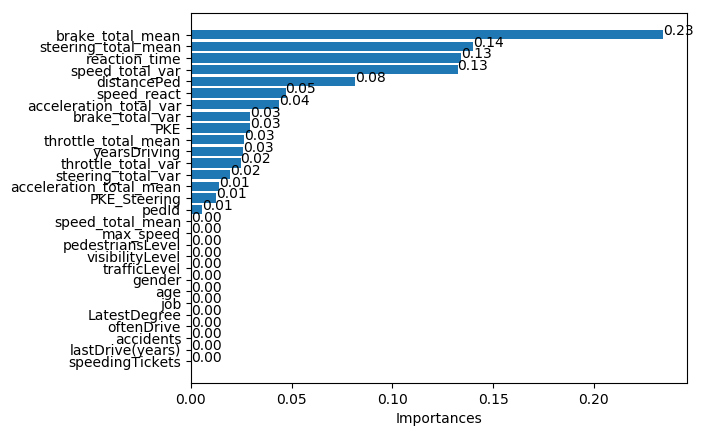

In [4]:
from sklearn.tree import DecisionTreeClassifier
data = df.copy()
X = data.drop('hadCollision', axis=1) 
Y = data['hadCollision']

classifier = DecisionTreeClassifier()
classifier.fit(X, Y)

importances_zip = zip(X.columns, classifier.feature_importances_)
importances_sorted = sorted(importances_zip, key=lambda tup: tup[1], reverse=True)
columns = []
importances = []
for name, importance in importances_sorted:
    columns.append(name)
    importances.append(importance)

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(columns, importances, align='center')
for index,value in enumerate(importances):
    ax.text(value, index, str("{:.2f}".format(value)))

ax.set_yticks(X.columns)
ax.set_yticklabels(X.columns)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importances')

plt.show()

Regarding this decision tree we can see that only 14 of 30 of the features has at least some of importance in order to predict if the driver will have a collision.

All scenario data seems to be less important, and also almost all of demographic data seems to be the same (perhaps here there is a failure when grouping the data).

The most importante feature is the brake pedal mean and also we have in third and sixth place the reaction time and breke pedal variance which is logic.

The initial distance with the pedestrian is also in second place so this can be some clue that the driver has or not a long time driving in order to discover the influence of possible distractions.

## Split data set

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=1, stratify=Y)

In [6]:
def print_split_data_set(X_train, X_test, y_train, y_test):
    print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
    print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
    print("")
    print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
    print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))
    
print_split_data_set(X_train, X_test, y_train, y_test)

Training True  : 22 (7.53%)
Training False : 270 (92.47%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


Normally I divide the data in 60% for training and 40% for test, having as target the column 'hadCollision'. I choose this percentages due to having a poor number of true cases. However I will try different combinations to see which has better results.

# Predictions

First I will start with the DecisionTree that made the feature importances plot.

### Auxiliar function for random repeats

In [7]:
def default_train_test_split(test_size):
    return train_test_split(X, Y, test_size=test_size, stratify=Y)

def repite_model_predict_algorithm( fit_function, predict_function, repetitions=50, test_size=0.4, split_fuction=default_train_test_split):
    y_pred_total = []
    y_test_total = []
    for i in range(repetitions):
        X_train, X_test, y_train, y_test = split_fuction(test_size)
        fit_function(X_train, y_train)
        y_pred = predict_function(X_test)
        y_pred_total.append(y_pred)
        y_test_total.append(y_test)
    
    y_test_total = [val for sublist in y_test_total for val in sublist]
    y_pred_total = [val for sublist in y_pred_total for val in sublist]
    lookup = {0: 'No Hit', 1:'Yes Hit'}
    y_true_pd = pd.Series([lookup[_] for _ in y_test_total])
    y_pred_pd = pd.Series([lookup[_] for _ in y_pred_total])
    
    summarize_results(y_true_pd, y_pred_pd)

    
def summarize_results(y_true_pd, y_pred_pd):
    print("Total Accuracy: %{0:.2f}".format(accuracy_score(y_true_pd, y_pred_pd)*100))
    print("")
    print("Confusion Matrix")
    print("")
    tab = pd.crosstab(y_true_pd, y_pred_pd, rownames=['True'], colnames=['Predicted'], margins=False)

    print(tab)
    print("")    
    plot_confusion_matrix(metrics.confusion_matrix(y_true_pd, y_pred_pd))

    #print("Classification Report")
    print("")
    cr = metrics.classification_report(y_true_pd, y_pred_pd)
    #print(cr)
    plot_classification_report(cr)

In [8]:
def plot_confusion_matrix(matrix):

    ax1 = pie_plot(1, 'No Hits predictions', matrix[0], ['g','r'], ['No Hit', 'Hit'])
    ax2 = pie_plot(2, 'Hits predictions recall', [matrix[1][1], matrix[1][0]], ['g','r'], ['Hit', 'No Hit'])

    plt.show()
    
def pie_plot(i, title, sizes, colors, labels):
    ax1 = plt.subplot(2,2,i)

    ax1.set_title(title)
    ax1.pie(sizes, explode=(0, 0.1), labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors)
    
    ax1.axis('equal')
    return ax1

## Decision Tree

Total Accuracy: %91.31

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     171558     8442
Yes Hit      8500     6500



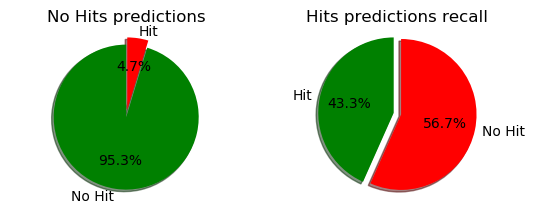

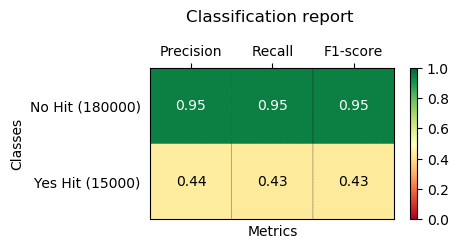

In [9]:
from sklearn.metrics import accuracy_score 
from sklearn import tree

clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4)

As we can see we have a good 'Total Accuracy' of 92 % and a good recall for false cases. The problem here is that it seems to be an overfitting given that the algorithm assert with almost the 96% false cases but when it is a true case we have around 48%. 

I decided to add two pie plots only to visualize the recall of both decisions, and in particular to show falses negatives percentage. In a real case we would try to avoid those negatives cases in order to avoid when the model predict that it will not be collision but it finally happens.

Regarding that, we can consider that the fact of having less true cases for training the model may be a problem for this investigation. However, we will try to see different approachs with the same data to deal with that.

As we can see in the Confusion Matrix we have almost 15 k true cases and we only predict almost 7k correctly.

Also this problem is repeated with 0.1, 0.2, 0.3 and 0.5 test_size.

## KNN classifier

### Search for best n neighbors number

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X, Y)
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 4}

### KNN classifier with n=4

Total Accuracy: %93.90

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      90622      378
Yes Hit      5596     1404



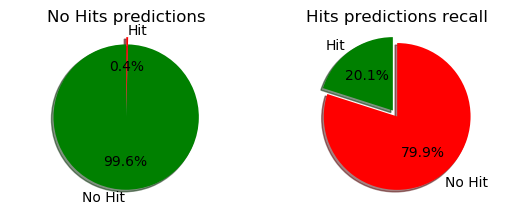

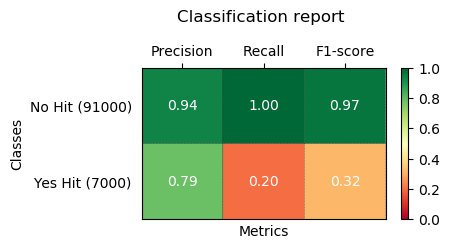

In [11]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.2)

This case is a clear example of overfitting. We have a huge percentage of correct 'No Hit Predictions' but the opposite with 'Hit predictions'. The model seems to be used to predict that the driver it's not going to crash which translates into a high percentage of false negatives cases.

I used 20% of data set for testing, because performs better in this case.

## Random Forest

Total Accuracy: %93.23

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     134173     1827
Yes Hit      8120     2880



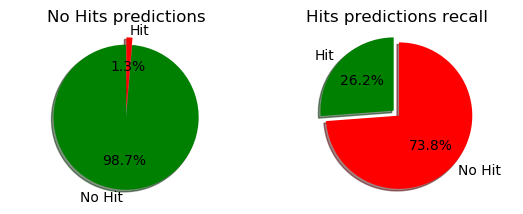

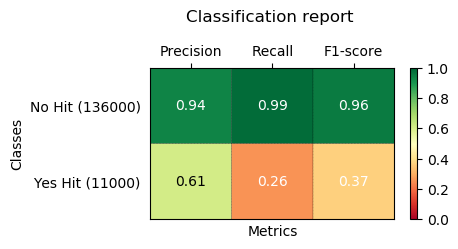

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)

The same problem can be seen with this model, the best recall achieved was %30 trying with different training sizes.

# Over sampling data

Now we will try increasing the numbers of true cases with different over sampling approachs:

## Random Over Sampler

In [13]:
from imblearn.over_sampling import RandomOverSampler

def random_over_sampler_split(test_size):
    ros = RandomOverSampler()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

def print_over_sampling_fuction(split_function, test_size):
    X_resampled, X_test, y_resampled, y_test = split_function(test_size)
    print_split_data_set(X_resampled, X_test, y_resampled, y_test)

In [14]:
print_over_sampling_fuction(random_over_sampler_split, 0.4)

Training True  : 270 (50.00%)
Training False : 270 (50.00%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


Here we can see that False cases were splitted normally and "Training True" cases are now equals to falses.

### Decision Tree

This algorith was ignore because results were worst than before (without over sampling data)

### KNN classifier

Total Accuracy: %87.97

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      82891     8109
Yes Hit      3680     3320



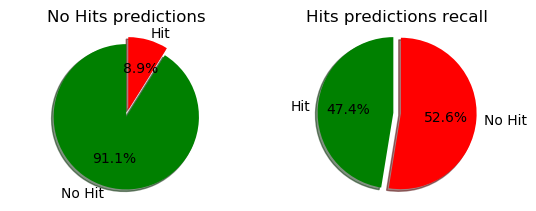

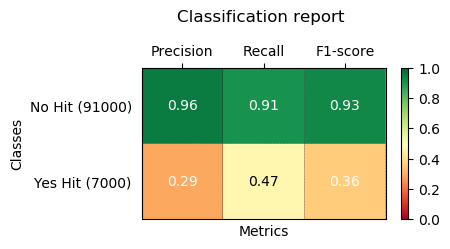

In [15]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.2, random_over_sampler_split)

With over sampling Knn seems to be better at recall, but it lose a lot of precision comparing without over sampling data.

### Random Forest

Total Accuracy: %93.02

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     177902     2098
Yes Hit     11518     3482



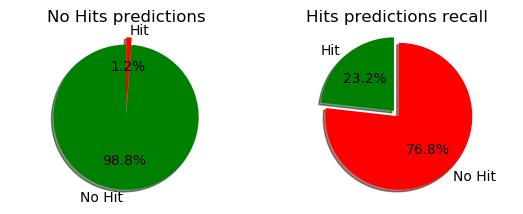

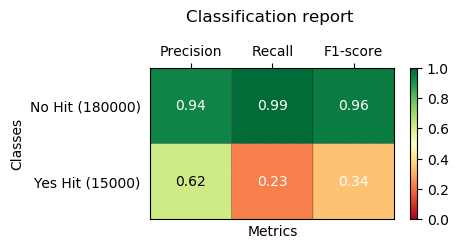

In [16]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.4, random_over_sampler_split)

For random forest there is no difference with random over sampling data.

## SMOTE

In [17]:
from imblearn.over_sampling import SMOTE, ADASYN

def smote_over_sampler_split(test_size):
    smote = SMOTE()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = smote.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

print_over_sampling_fuction(smote_over_sampler_split, 0.4)

Training True  : 270 (50.00%)
Training False : 270 (50.00%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


### Decision Tree

Total Accuracy: %87.23

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     164411    15589
Yes Hit      9322     5678



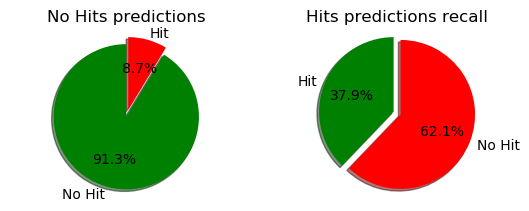

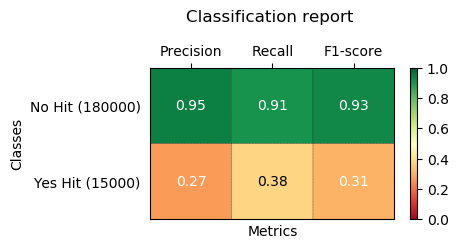

In [18]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4, smote_over_sampler_split)

Decision Tree doesn't change results with over sampling data.

### KNN classifier

Total Accuracy: %83.97

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      78682    12318
Yes Hit      3391     3609



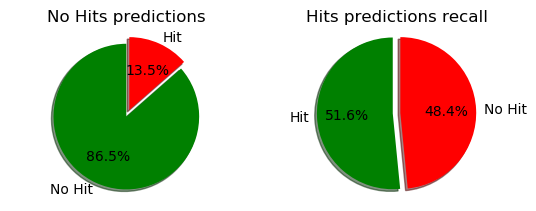

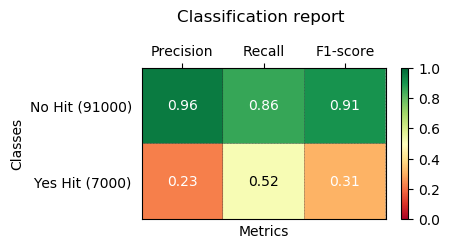

In [19]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.2, smote_over_sampler_split)

With Smote we have better Recall but worst precision.

### Random Forest

Total Accuracy: %92.02

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     131892     4108
Yes Hit      7625     3375



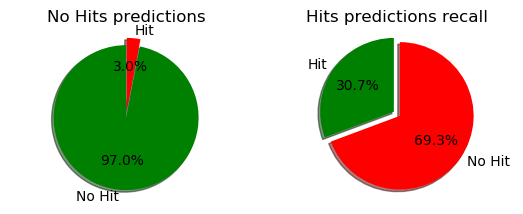

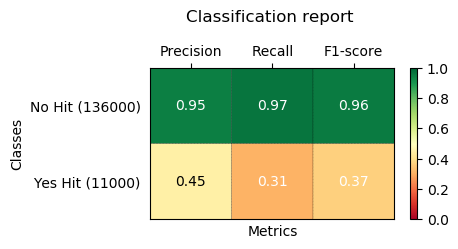

In [20]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3, smote_over_sampler_split)

This are similars results as Randon Forest without over sampling, but with a considerable worst precision. It is still possible to notice the overfitting.

## ADASYN

In [21]:
def adasyn_over_sampler_split(test_size):
    adasyn = ADASYN()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = adasyn.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

print_over_sampling_fuction(adasyn_over_sampler_split, 0.4)

Training True  : 266 (49.63%)
Training False : 270 (50.37%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


This oversampling it's not totally exactly when doing the true training cases. So it's not exactly 50% of each.

### Decision Tree

Ignored

### KNN classifier

Total Accuracy: %74.93

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     137928    42072
Yes Hit      6815     8185



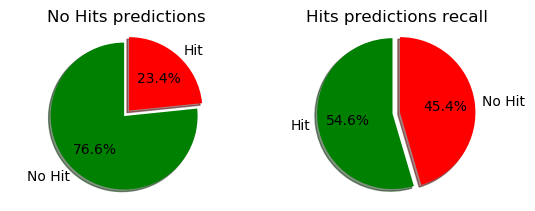

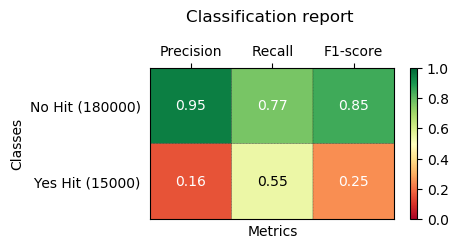

In [22]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.4, adasyn_over_sampler_split)

Similar recall to Smote but worst precision.

### Random Forest

Total Accuracy: %90.70

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     173431     6569
Yes Hit     11574     3426



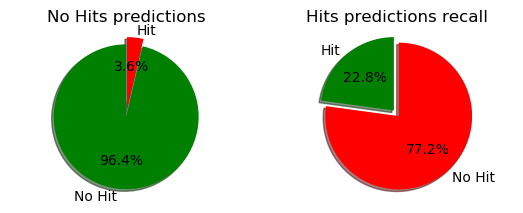

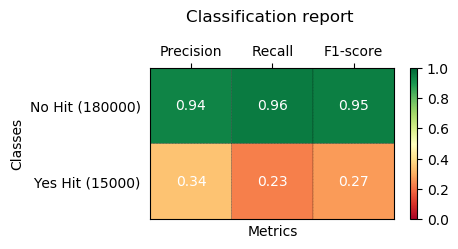

In [23]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.4, adasyn_over_sampler_split)

Worst results than smote and no over sampling.

# Changing training data

I will try training the data with the same numbers of false cases and true cases but this time with less false cases:

In [24]:
def equal_cases_split(training_size_positives):
    return split_cases(training_size_positives, training_size_positives)

def double_false_cases_split(training_size_positives):
    return split_cases(training_size_positives, training_size_positives*2)

def split_cases(positive_training_size, negative_training_size):
    positives = data.loc[df['hadCollision'] == 1].copy()
    negatives = data.loc[df['hadCollision'] == 0].copy()
    test_size_pos = len(positives) - positive_training_size
    test_size_neg = len(negatives) - negative_training_size

    X_train_pos, X_test_pos = train_test_split(positives, train_size=positive_training_size, test_size=test_size_pos)
    X_train_neg, X_test_neg = train_test_split(negatives, train_size=negative_training_size, test_size=test_size_neg)
    X_train_total = X_train_pos.append(X_train_neg)
    X_test_total = X_test_pos.append(X_test_neg)

    X_train_total = X_train_total.sample(frac=1).reset_index(drop=True)
    X_test_total = X_test_total.sample(frac=1).reset_index(drop=True)
    X_train = X_train_total.drop('hadCollision', axis=1) 
    y_train = X_train_total['hadCollision']

    X_test = X_test_total.drop('hadCollision', axis=1) 
    y_test = X_test_total['hadCollision']
    return X_train, X_test, y_train, y_test

def print_results_with_size(split_function, train_size_pos):
    X_train, X_test, y_train, y_test = split_function(train_size_pos)
    print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
    print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
    print("")
    print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
    print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))

In [25]:
print_results_with_size(equal_cases_split, 30)

Training True  : 30 (50.00%)
Training False : 30 (50.00%)

Test True      : 7 (1.64%)
Test False     : 420 (98.36%)


We have now a training set of only 60 cases with 50% hits and 50% no hits. I decided to take 30 true cases as it's almost de 80% of true cases for training.

### Decision Tree

Total Accuracy: %73.35

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     308267   111733
Yes Hit      2047     4953



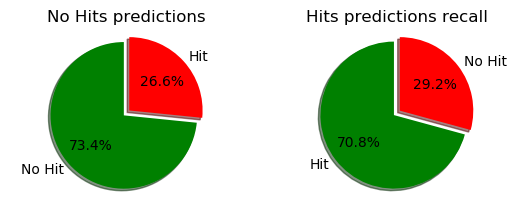

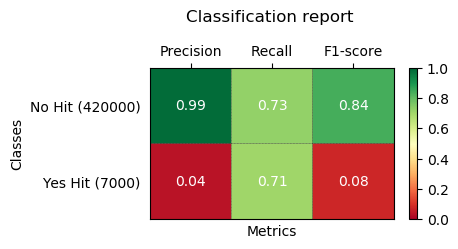

In [26]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 30, equal_cases_split)

The recall is strongly increased with this approach, but now the "No hit" predictions are not as good as before and that makes a presicion for "Yes Hit"'s cases really bad due to compare 5k correct predictions with more than 100k false positives.

In [27]:
print_results_with_size(double_false_cases_split, 20)

Training True  : 20 (33.33%)
Training False : 40 (66.67%)

Test True      : 17 (3.98%)
Test False     : 410 (96.02%)


Trying with the double of false cases for training in order to get more precision of "Yes Hit" cases, but this time taking only 20 true cases for training.

Total Accuracy: %81.79

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     338498    71502
Yes Hit      6259    10741



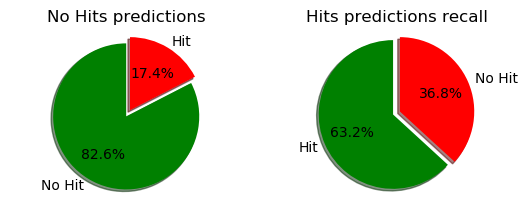

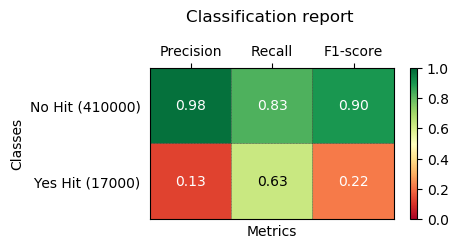

In [28]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 20, double_false_cases_split)

We could increase the recall of "No Hit", which affects to "Yes Hit" precision on almost the triple, but is still low. 

### Knn

Total Accuracy: %87.49

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     369915    50085
Yes Hit      3328     3672



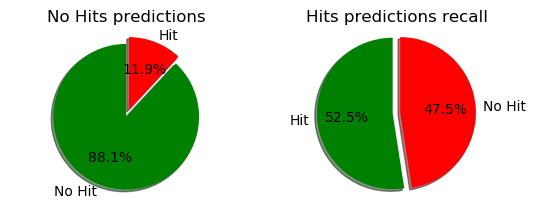

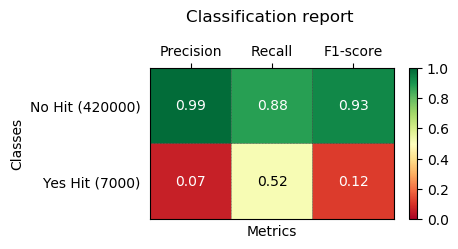

In [29]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  30, equal_cases_split)

Worst metrics as before

Total Accuracy: %94.97

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     374017    15983
Yes Hit      3972     3028



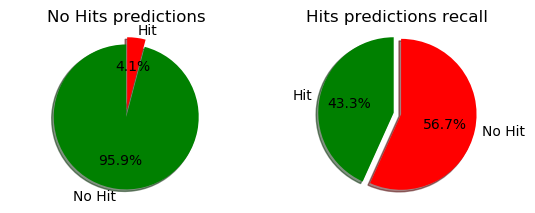

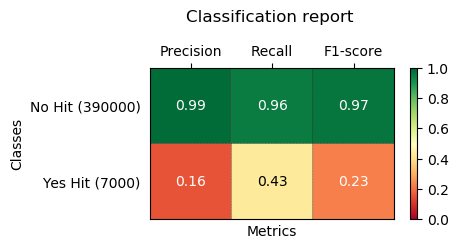

In [30]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  30, double_false_cases_split)

We recorver the recall of "No Hits" predictions but it's not enougth to have good precision of "Yes Hit"

### Random Forest

Total Accuracy: %81.64

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     343710    76290
Yes Hit      2126     4874



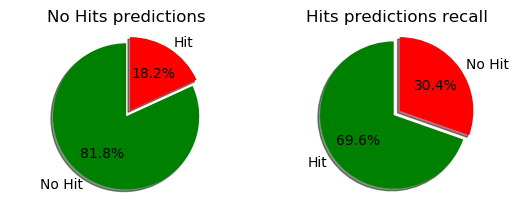

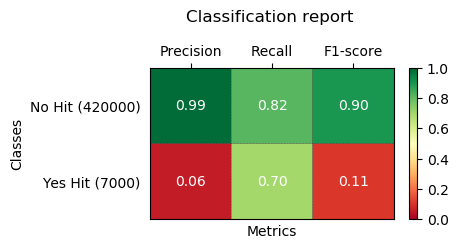

In [31]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 30, equal_cases_split)

The recall it's considerable better with this configuration. However the model now seems to see a lot of cases positives than before. This doesn't affect "No hit" precision or recall, but the precision of "Yes Hit" cases it's considerable worst than before. This means we have now a lot of False Positive cases.

We can see in the confusion matrix that almost 72k cases were predicted with a collision and there were false hits. In real life this will be a problem because we would be alerting for nothing really, but in fact it is not as important as the opposite case.

Total Accuracy: %90.25

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     376359    33641
Yes Hit      7976     9024



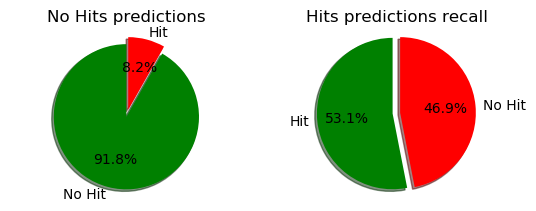

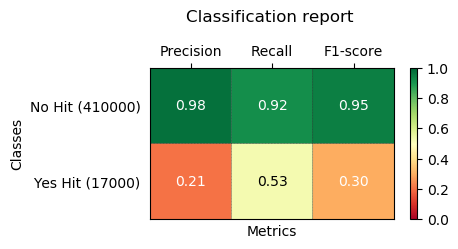

In [32]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 20, double_false_cases_split)

There is an improvement with the precision of "Yes Hit" but still low. On the other hand, the recall of "Yes Hit" it's not as good as before, but in the combination of both (f1-score) this is a better configuration.

The preference on the result will depend on the weigth of those classes.

# Weights classes

## Balanced

### Decision Tree

Total Accuracy: %90.22

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      86340     4660
Yes Hit      4924     2076



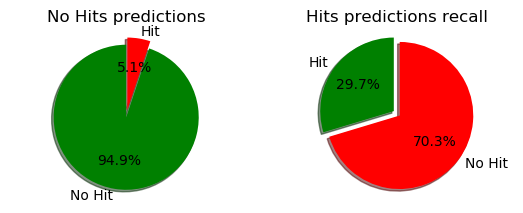

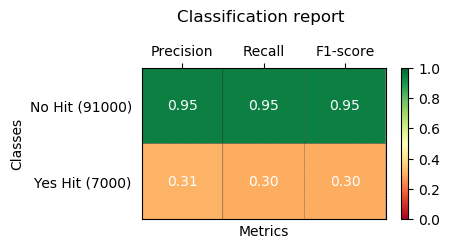

In [33]:
clf = tree.DecisionTreeClassifier(class_weight='balanced')

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.2)

Worst than default case.

### KNN

Default value is 'uniform' or balance, so I will try with distance

Total Accuracy: %93.30

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     177926     2074
Yes Hit     10991     4009



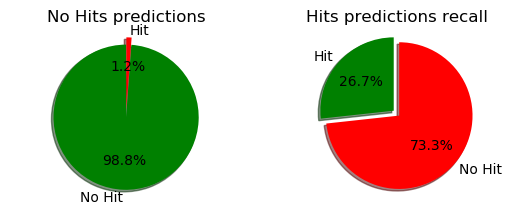

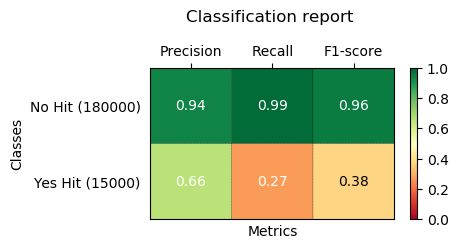

In [34]:
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  0.4)

Same overfitting as default case

### Random Forest

#### Balanced

Total Accuracy: %93.01

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     135462      538
Yes Hit      9732     1268



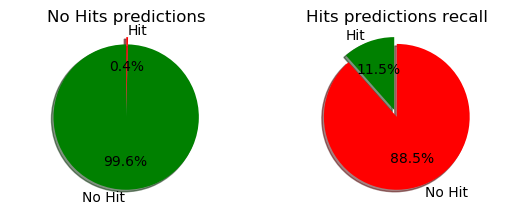

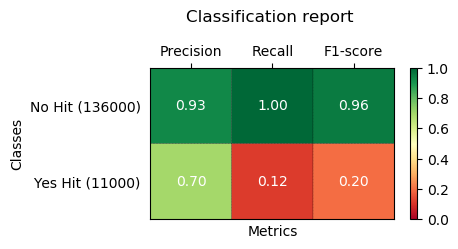

In [35]:
rf_model = RandomForestClassifier(class_weight="balanced")
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)

Same overfitting as default.

#### Balanced Subsample

Total Accuracy: %93.04

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     135465      535
Yes Hit      9702     1298



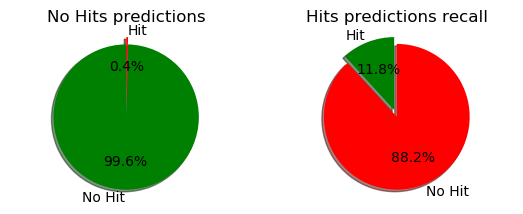

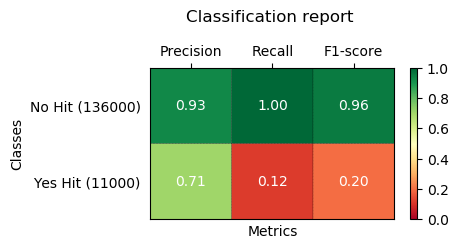

In [36]:
rf_model = RandomForestClassifier(class_weight="balanced_subsample")
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)

Same overfitting as default

### Decision Tree

In [37]:
from IPython.core.display import display, Markdown

def print_header(header):
    raw_html = "<h3>"+header+"</h3>"
    display( Markdown(raw_html) )

<h3>Running: Default model-prediction</h3>

Total Accuracy: %91.35

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     170883     9117
Yes Hit      7756     7244



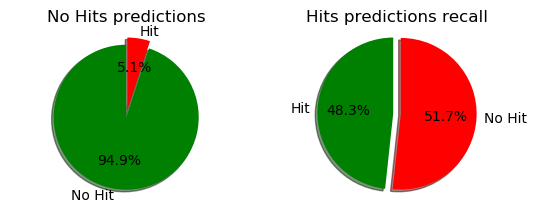

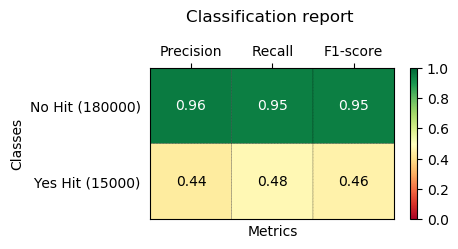

<h3>Running: Random Over Sampler</h3>

Total Accuracy: %91.41

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      86605     4395
Yes Hit      4023     2977



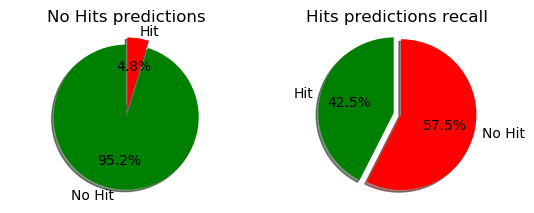

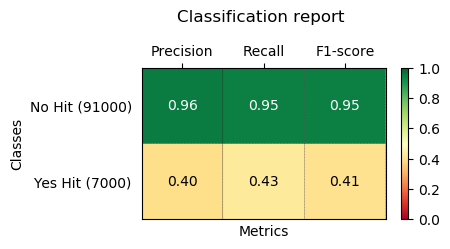

<h3>Running: SMOTE</h3>

Total Accuracy: %87.87

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     162627    17373
Yes Hit      6284     8716



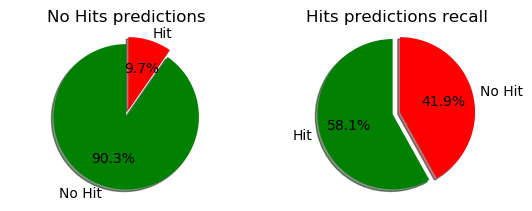

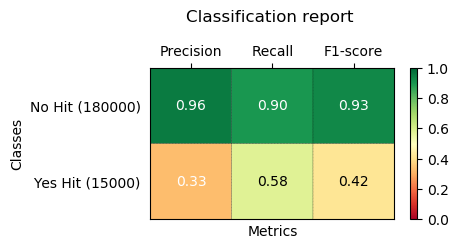

<h3>Running: ADASYN</h3>

Total Accuracy: %69.45

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     126414    53586
Yes Hit      5991     9009



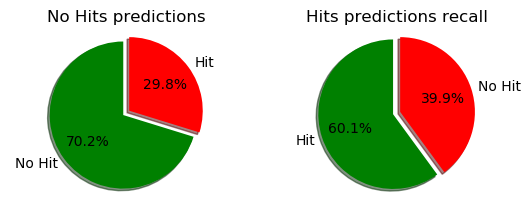

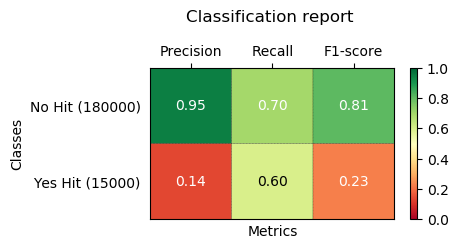

<h3>Running: Equal training cases</h3>

Total Accuracy: %74.69

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     313413   106587
Yes Hit      1504     5496



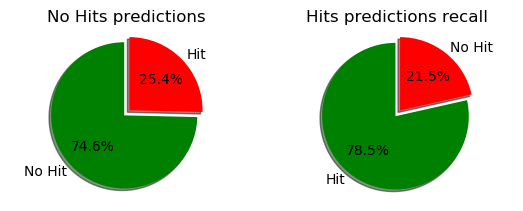

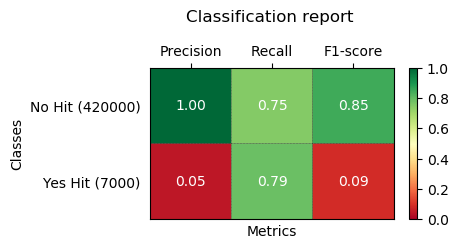

<h3>Running: Double false training cases</h3>

Total Accuracy: %83.41

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     326052    63948
Yes Hit      1911     5089



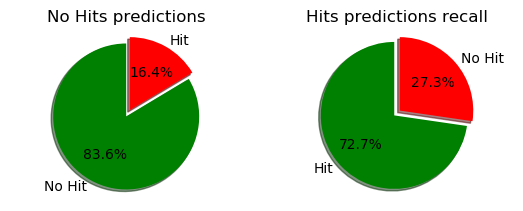

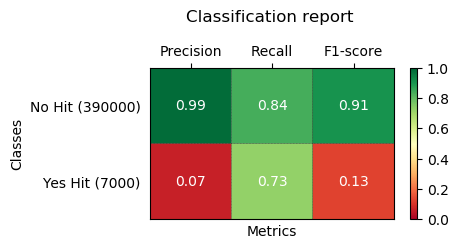

In [38]:
def run_all_models(clf):
    print_header("Running: Default model-prediction")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4)

    print_header("Running: Random Over Sampler")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.2, random_over_sampler_split)

    print_header("Running: SMOTE")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4, smote_over_sampler_split)

    print_header("Running: ADASYN")

    repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.4, adasyn_over_sampler_split)

    print_header("Running: Equal training cases")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 30, equal_cases_split)

    print_header("Running: Double false training cases")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 30, double_false_cases_split)
    
clf = tree.DecisionTreeClassifier(class_weight={0:10, 1:1})
run_all_models(clf)

Regarding Hits predictions recall we can see a really good performance with "Equal training cases" but again still a bad precision for this class. 

Regarding F1-score, it means seen precision and recall, we acceptable performances with Smote and Random over samplers, and with default case we have a similar performance in each component.

### Knn

I didn't find Knn class_weigths, it has a function weigth but I think is only weigths per feature:
    
    - [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.

### Random Forest

<h3>Running: Default model-prediction</h3>

Total Accuracy: %93.18

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     133249     2751
Yes Hit      7278     3722



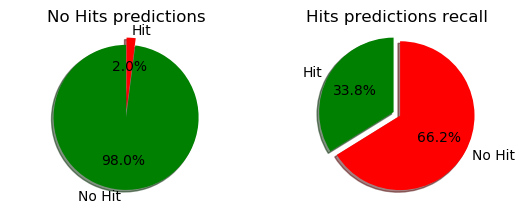

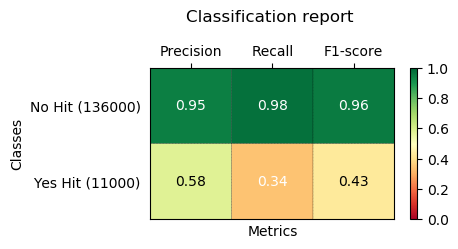

<h3>Running: Random Over Sampler</h3>

Total Accuracy: %93.07

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     175648     4352
Yes Hit      9166     5834



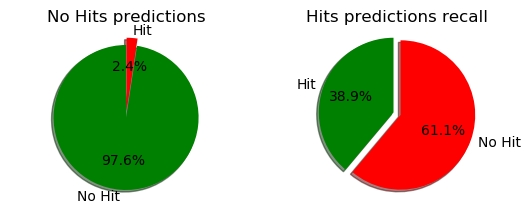

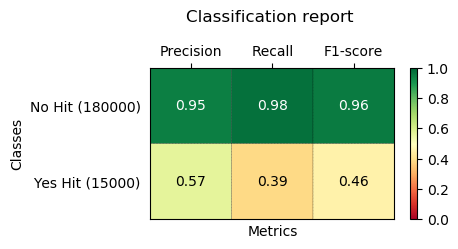

<h3>Running: SMOTE</h3>

Total Accuracy: %91.42

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     128009     7991
Yes Hit      4617     6383



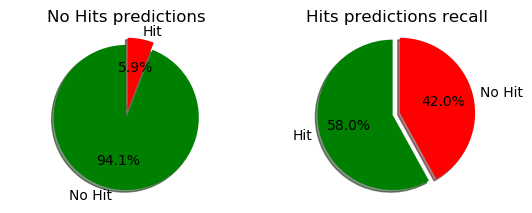

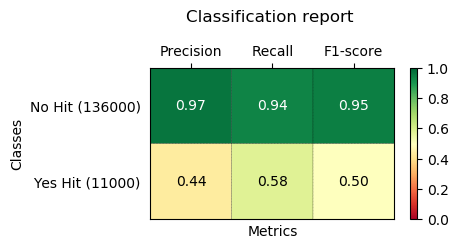

<h3>Running: ADASYN</h3>

Total Accuracy: %89.26

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     165356    14644
Yes Hit      6294     8706



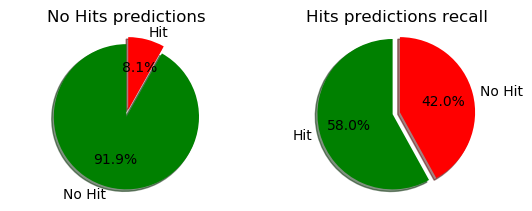

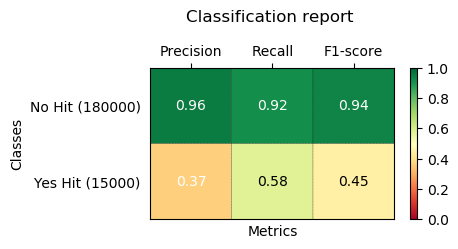

<h3>Running: Equal training cases</h3>

Total Accuracy: %80.81

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     339674    80326
Yes Hit      1610     5390



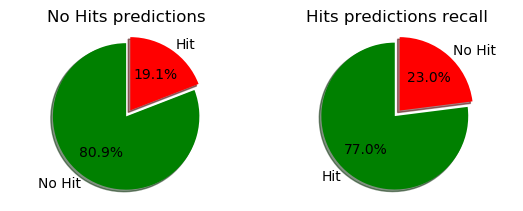

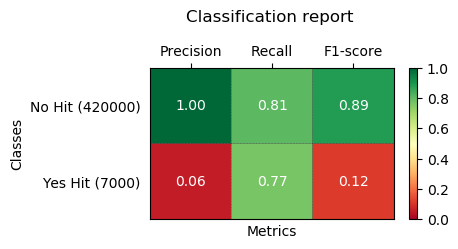

<h3>Running: Double false training cases</h3>

Total Accuracy: %89.54

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     350782    39218
Yes Hit      2308     4692



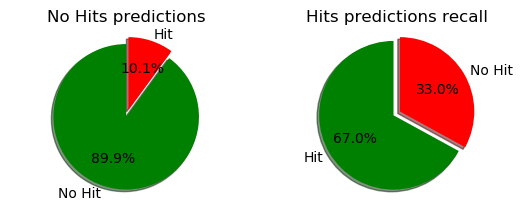

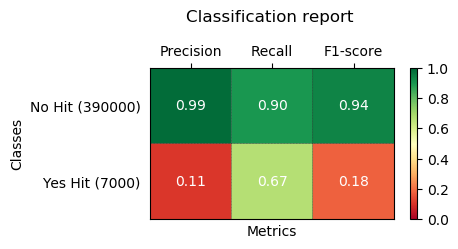

In [39]:
def run_all_models(rf_model):
    print_header("Running: Default model-prediction")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)
    
    print_header("Running: Random Over Sampler")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.4, random_over_sampler_split)

    print_header("Running: SMOTE")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3, smote_over_sampler_split)

    print_header("Running: ADASYN")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.4, adasyn_over_sampler_split)
    
    print_header("Running: Equal training cases")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 30, equal_cases_split)

    print_header("Running: Double false training cases")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 30, double_false_cases_split)
    
rf_model = RandomForestClassifier(class_weight={0:10, 1:1})
run_all_models(rf_model)

We can see again very good recalls for Hits predictions in Equal and Double False training cases. However regarding both variables Precision and Recall, the best prediction seems to be with SMOTE over sampling having acceptables metrics in both.